# Visualizing the effect of G1/G2/V1 in UKB AFR (and comparison with EUR when applicable)

In [1]:
import pandas as pd
import numpy as np
import time as tm
import os
import dxdata
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [2]:
#First get the v1, g1m, g1g and g2 in UKB exome:

ans = pd.read_csv("/mnt/project/Datasets/Ancestry/panukbb_ancestry.txt", sep="\t", index_col=0)
ans.rename(columns={"pop":"population"}, inplace=True) #original bad naming..
ans.set_index("individual_id", inplace=True)
ans = ans[~ans.index.duplicated(keep="first")]
ans.index = ans.index.astype(str).astype(object)

fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.sample"
sns = pd.read_csv(fn, sep=" ")
sns = sns.iloc[1:,:]
sns.set_index("ID_1", inplace=True)
sns.index = sns.index.astype(int).astype(str).astype(object)
sns = sns[~sns.index.duplicated(keep="first")]
sns = sns.join(ans.population, how="left")
sns.reset_index(inplace=True)
touse_idx = sns[(sns.population=="EUR") | (sns.population=="AFR")].index
touse_samples = sns[(sns.population=="EUR") | (sns.population=="AFR")].ID_1

/tmp/ipykernel_1496/2940133752.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sns = pd.read_csv(fn, sep=" ")


In [116]:
g12 = ["22:36265988:T:G", "22:36265860:A:G", "22:36265995:AATAATT:A", "22:36265284:G:A"]
g12names = ["G1M", "G1G", "G2", "V1"]

from bgen import BgenReader
fn = "/mnt/project/Bulk/Exome sequences/Population level exome OQFE variants, BGEN format - final release/ukb23159_c22_b0_v1.bgen"
bfile = BgenReader(fn)
dosages = []
for vname in g12:
    v = bfile.with_rsid(vname)[0]
    dos = pd.Series(v.alt_dosage[touse_idx])
    dosages.append(dos)

In [ ]:
dosages = pd.concat(dosages,axis=1)
dosages.columns = g12names
dosages.index = touse_samples

In [118]:
d_eur = dosages.loc[dosages.index.intersection(sns[(sns.population=="EUR")].ID_1),:]
d_afr = dosages.loc[dosages.index.intersection(sns[(sns.population=="AFR")].ID_1),:]

In [3]:
#apol1:
DATASET_ID = "REDACTED"
dataset = dxdata.load_dataset(id=DATASET_ID)
olinkdata = dataset['olink_instance_0']
field_apol1 = olinkdata.find_field(name="apol1")
field_eid = olinkdata.find_field(name="eid")
apol1 = olinkdata.retrieve_fields(engine=dxdata.connect(), fields=[field_eid, field_apol1], coding_values="replace")
apol1 = apol1.toPandas()
apol1.set_index("eid", inplace=True)
apol1 = apol1.squeeze()

In [121]:
d_eur = d_eur.join(apol1, how="inner")
d_afr = d_afr.join(apol1, how="inner")

In [123]:
d_afr = d_afr[~d_afr.apol1.isna()]
d_eur = d_eur[~d_eur.apol1.isna()]

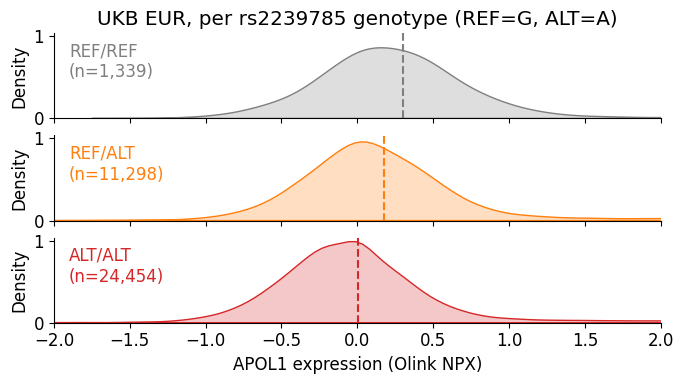

In [125]:
#V1 effect in EUR:
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_eur.V1==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_eur.V1==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_eur.V1==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_eur[d_eur.V1==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-1.9, y=0.5, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB EUR, per rs2239785 genotype (REF=G, ALT=A)")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-2,2])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("v1_eur_kde.png", dpi=500)
plt.savefig("v1_eur_kde.pdf", dpi=500)
plt.show()
plt.close()

In [126]:
#G1,G2 and V1 in AFR:

#V1:
d_afr.iloc[:,:4].value_counts().unstack()
#For main eff, filter to G1/G2 = REF/REF

V1             0.0    1.0   2.0
G1M G1G G2                     
0.0 0.0 0.0   61.0  128.0  61.0
        1.0   42.0   62.0   8.0
        2.0   20.0    2.0   3.0
    1.0 0.0    NaN    4.0   1.0
1.0 1.0 0.0  124.0  117.0   NaN
        1.0   64.0    7.0   NaN
    2.0 0.0    2.0    NaN   NaN
2.0 2.0 0.0   71.0    NaN   NaN

## Confirming that V1 has effect on top of G1/G2 effect in AFR:

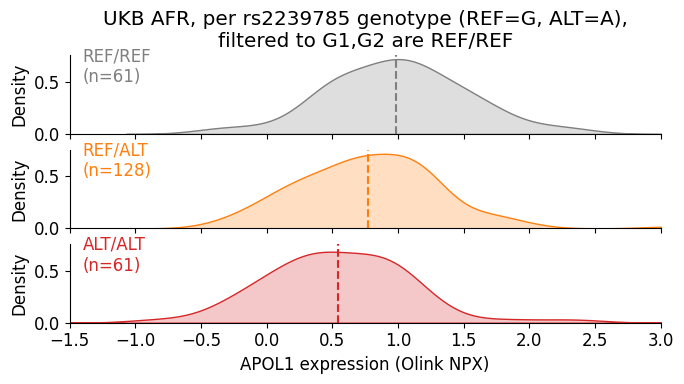

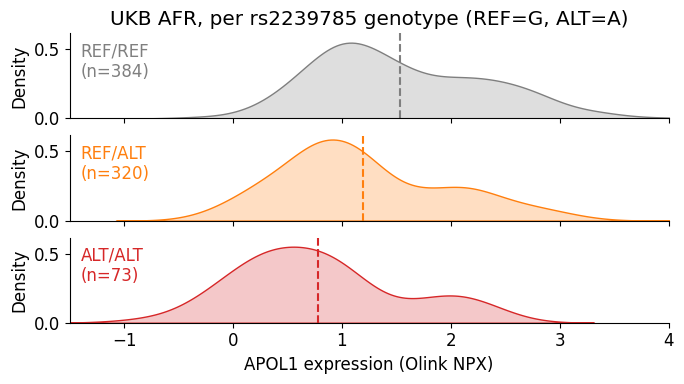

In [127]:
d_afr_v1 = d_afr[(d_afr.G1M==0)&(d_afr.G1G==0)&(d_afr.G2==0)]
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_afr_v1.V1==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_afr_v1.V1==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_afr_v1.V1==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_afr_v1[d_afr_v1.V1==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-1.4, y=0.5, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB AFR, per rs2239785 genotype (REF=G, ALT=A),\nfiltered to G1,G2 are REF/REF")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-1.5,3])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("v1_afr_kde_filtg1g2.png", dpi=500)
plt.savefig("v1_afr_kde_filtg1g2.pdf", dpi=500)
plt.show()
plt.close()

#No filter:
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_afr.V1==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_afr.V1==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_afr.V1==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_afr[d_afr.V1==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-1.4, y=0.3, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB AFR, per rs2239785 genotype (REF=G, ALT=A)")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-1.5,4])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("v1_afr_kde.png", dpi=500)
plt.savefig("v1_afr_kde.pdf", dpi=500)
plt.show()
plt.close()

In [128]:
#G2 eff:
d_afr.loc[:,["G1M","G1G","V1","G2"]].value_counts().unstack()

G2             0.0   1.0   2.0
G1M G1G V1                    
0.0 0.0 0.0   61.0  42.0  20.0
        1.0  128.0  62.0   2.0
        2.0   61.0   8.0   3.0
    1.0 1.0    4.0   NaN   NaN
        2.0    1.0   NaN   NaN
1.0 1.0 0.0  124.0  64.0   NaN
        1.0  117.0   7.0   NaN
    2.0 0.0    2.0   NaN   NaN
2.0 2.0 0.0   71.0   NaN   NaN

## Visualizing G2 effect marginally and on top of G1 and V1:

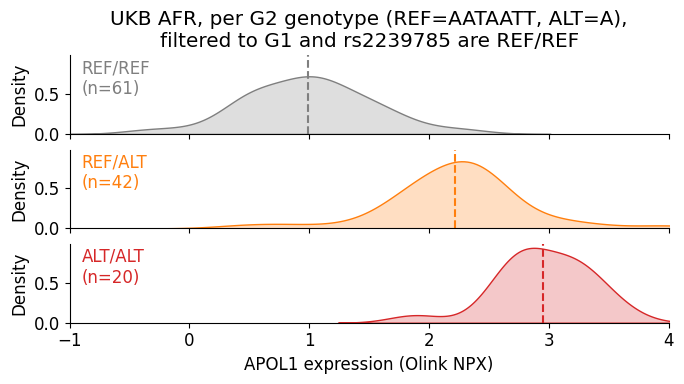

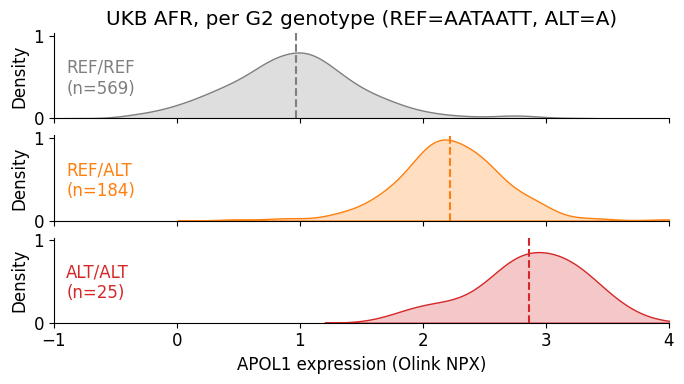

In [129]:
d_afr_g2 = d_afr[(d_afr.G1M==0)&(d_afr.G1G==0)&(d_afr.V1==0)]
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_afr_g2.G2==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_afr_g2.G2==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_afr_g2.G2==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_afr_g2[d_afr_g2.G2==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-0.9, y=0.5, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB AFR, per G2 genotype (REF=AATAATT, ALT=A),\nfiltered to G1 and rs2239785 are REF/REF")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-1,4])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("g2_afr_kde_filtg1v1.png", dpi=500)
plt.savefig("g2_afr_kde_filtg1v1.pdf", dpi=500)
plt.show()
plt.close()

#No filter:
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_afr.G2==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_afr.G2==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_afr.G2==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_afr[d_afr.G2==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-0.9, y=0.3, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB AFR, per G2 genotype (REF=AATAATT, ALT=A)")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-1,4])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("g2_afr_kde.png", dpi=500)
plt.savefig("g2_afr_kde.pdf", dpi=500)
plt.show()
plt.close()

In [130]:
#G1 eff:
print ((d_afr.G1M==d_afr.G1G).value_counts())
d_afr_forg1 = d_afr[d_afr.G1M==d_afr.G1G]
d_afr_forg1.loc[:,["V1","G2", "G1M"]].value_counts().unstack()

True     771
False      7
dtype: int64


G1M        0.0    1.0   2.0
V1  G2                     
0.0 0.0   61.0  124.0  71.0
    1.0   42.0   64.0   NaN
    2.0   20.0    NaN   NaN
1.0 0.0  128.0  117.0   NaN
    1.0   62.0    7.0   NaN
    2.0    2.0    NaN   NaN
2.0 0.0   61.0    NaN   NaN
    1.0    8.0    NaN   NaN
    2.0    3.0    NaN   NaN

## Visualizing G1 effect marginally and on top of G2 and V1:

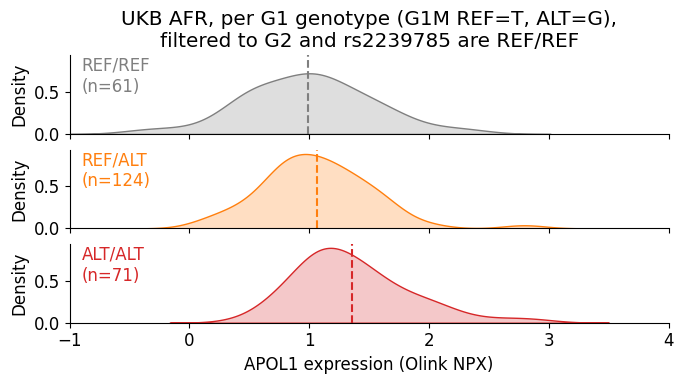

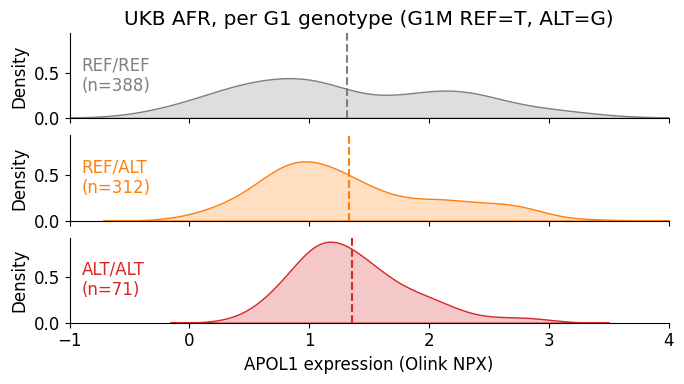

In [131]:
d_afr_g1 = d_afr[(d_afr.G1M==d_afr.G1G)&(d_afr.G2==0)&(d_afr.V1==0)]
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_afr_g1.G1M==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_afr_g1.G1M==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_afr_g1.G1M==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_afr_g1[d_afr_g1.G1M==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-0.9, y=0.5, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB AFR, per G1 genotype (G1M REF=T, ALT=G),\nfiltered to G2 and rs2239785 are REF/REF")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-1,4])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("g1_afr_kde_filtg2v1.png", dpi=500)
plt.savefig("g1_afr_kde_filtg2v1.pdf", dpi=500)
plt.show()
plt.close()

#No filter:
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF\n(n={:,})".format(sum(d_afr_forg1.G1M==0)), 
          "REF/ALT\n(n={:,})".format(sum(d_afr_forg1.G1M==1)), 
          "ALT/ALT\n(n={:,})".format(sum(d_afr_forg1.G1M==2))]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,4), sharex=True, sharey=True)
for i in range(3):
    d = d_afr_forg1[d_afr_forg1.G1M==i]
    sns.kdeplot(d.apol1, color=colors[i], fill=True, ax=ax[i])
    ax[i].axvline(x=d.apol1.mean(), linestyle='--', color=colors[i])    
    ax[i].text(x=-0.9, y=0.3, s=labels[i], color=colors[i])
    ax[i].set_ylabel("Density")
ax[0].set_title("UKB AFR, per G1 genotype (G1M REF=T, ALT=G)")
ax[2].set_xlabel("APOL1 expression (Olink NPX)")
ax[2].set_xlim([-1,4])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("g1_afr_kde.png", dpi=500)
plt.savefig("g1_afr_kde.pdf", dpi=500)
plt.show()
plt.close()

## Visualizing APOL1_olink difference between AFR vs EUR:

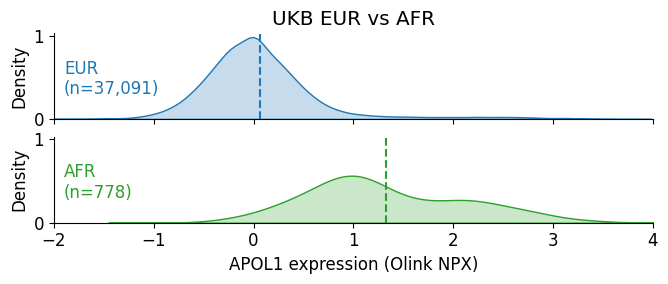

In [132]:
colors = ["tab:blue", "tab:green"]
labels = ["EUR\n(n={:,})".format(d_eur.shape[0]), 
          "AFR\n(n={:,})".format(d_afr.shape[0])]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,3), sharex=True, sharey=True)
sns.kdeplot(d_eur.apol1, color=colors[0], fill=True, ax=ax[0])
ax[0].axvline(x=d_eur.apol1.mean(), linestyle='--', color=colors[0])    
ax[0].text(x=-1.9, y=0.3, s=labels[0], color=colors[0])
ax[0].set_ylabel("Density")
sns.kdeplot(d_afr.apol1, color=colors[1], fill=True, ax=ax[1])
ax[1].axvline(x=d_afr.apol1.mean(), linestyle='--', color=colors[1])    
ax[1].text(x=-1.9, y=0.3, s=labels[1], color=colors[1])
ax[1].set_ylabel("Density")
ax[0].set_title("UKB EUR vs AFR")
ax[1].set_xlabel("APOL1 expression (Olink NPX)")
ax[1].set_xlim([-2,4])
for a in ax.flat:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)    
plt.tight_layout()
fig.subplots_adjust(hspace=0.2)
plt.savefig("afr_vs_eur_kde.png", dpi=500)
plt.savefig("afr_vs_eur_kde.pdf", dpi=500)
plt.show()
plt.close()

# Next we are going to look at interaction (i.e. whether one's effect changes given the others' genotype)

## Testing G1 and G2 interaction filtering to V1=REF/REF

In [133]:
d_afr[["V1","G1M","G2"]].value_counts().unstack()

G2         0.0   1.0   2.0
V1  G1M                   
0.0 0.0   61.0  42.0  20.0
    1.0  126.0  64.0   NaN
    2.0   71.0   NaN   NaN
1.0 0.0  132.0  62.0   2.0
    1.0  117.0   7.0   NaN
2.0 0.0   62.0   8.0   3.0

/tmp/ipykernel_106/2920498460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_g12["rd"] = np.random.rand(d_g12.shape[0])


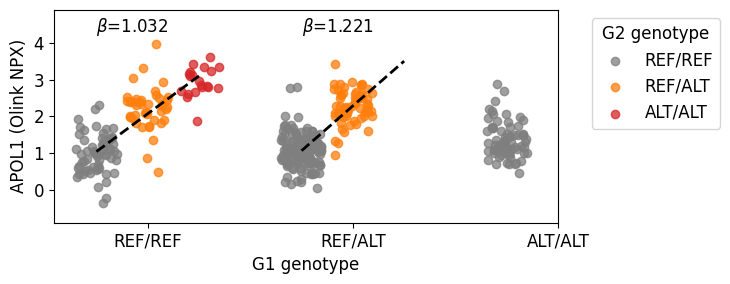

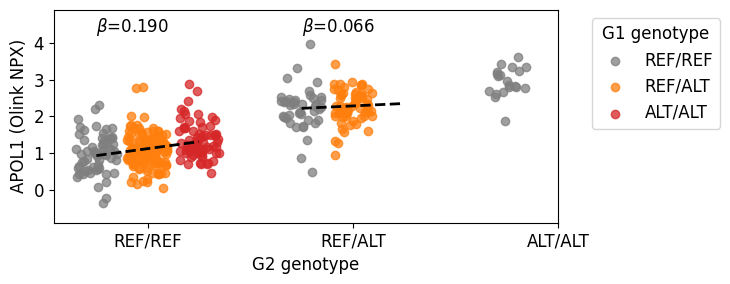

In [155]:
#Formalize this:
from sklearn.linear_model import LinearRegression
np.random.seed(3)
d_g12["rd"] = np.random.rand(d_g12.shape[0])
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF","REF/ALT", "ALT/ALT"]

#Plot:
plt.figure(figsize=(7.5,3))
for i in range(3):
    for j in range(3):
        d = d_g12[(d_g12.G1M==i)&(d_g12.G2==j)]
        if i==0:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], label=labels[j], alpha=0.75)
        else:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], alpha=0.75)
        #mu = d.apol1.mean()
        #plt.plot([i+(j-1)/4 - 1/5, i+(j-1)/4 + 1/5], [mu,mu], color=colors[j], linestyle="--", linewidth=2)        
#Regression line:
for i in range(2):
    model = LinearRegression()
    model.fit(pd.DataFrame(d_g12[(d_g12.G1M==i)].G2), d_g12[(d_g12.G1M==i)].apol1)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot([i-1/4,i+1/4],np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")
    plt.text(i-1/4, 4.3, f"$\\beta$={slope:.3f}")
plt.legend(title="G2 genotype", bbox_to_anchor=(1.05,1))
plt.xlabel("G1 genotype")
plt.ylabel("APOL1 (Olink NPX)")
plt.xticks([0,1,2],labels)
plt.ylim([-0.9,4.9])
plt.tight_layout()
plt.savefig("g1g2_intr.png", dpi=500)
plt.savefig("g1g2_intr.pdf", dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(7.5,3))
for i in range(3):
    for j in range(3):
        d = d_g12[(d_g12.G1M==j)&(d_g12.G2==i)]
        if i==0:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], label=labels[j], alpha=0.75)
        else:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], alpha=0.75)
#Regression line:
for i in range(2):
    model = LinearRegression()
    model.fit(pd.DataFrame(d_g12[(d_g12.G2==i)].G1M), d_g12[(d_g12.G2==i)].apol1)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot([i-1/4,i+1/4],np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")            
    plt.text(i-1/4, 4.3, f"$\\beta$={slope:.3f}")
plt.legend(title="G1 genotype", bbox_to_anchor=(1.05,1))
plt.xlabel("G2 genotype")
plt.ylabel("APOL1 (Olink NPX)")
plt.xticks([0,1,2],labels)
plt.ylim([-0.9,4.9])
plt.tight_layout()
plt.savefig("g1g2_intr2.png", dpi=500)
plt.savefig("g1g2_intr2.pdf", dpi=500)
plt.show()
plt.close()

## Testing V1-G2 interaction: need to filter to G1M=0 due to LD

In [96]:
d_afr[["G1M","V1","G2"]].value_counts().unstack()

G2         0.0   1.0   2.0
G1M V1                    
0.0 0.0   72.0  47.0  20.0
    1.0  147.0  72.0   3.0
    2.0   72.0  10.0   3.0
1.0 0.0  140.0  67.0   NaN
    1.0  136.0   8.0   NaN
2.0 0.0   80.0   NaN   NaN

/tmp/ipykernel_106/2670661895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_v1g2.dropna(inplace=True)
/tmp/ipykernel_106/2670661895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_v1g2["rd"] = np.random.rand(d_v1g2.shape[0])


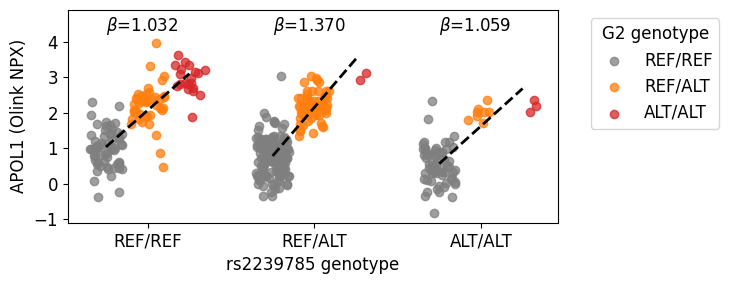

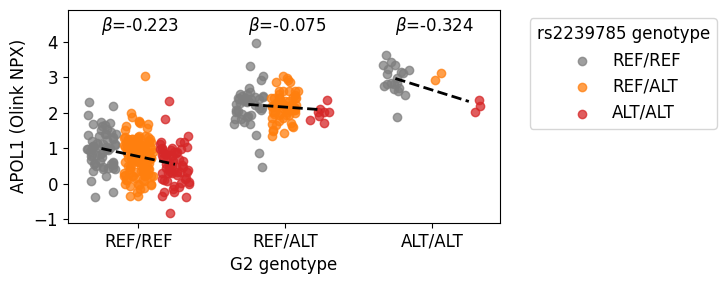

In [168]:
d_v1g2 = d_afr[(d_afr.G1M==0)&(d_afr.G1G==0)]
d_v1g2.dropna(inplace=True)
np.random.seed(3)
d_v1g2["rd"] = np.random.rand(d_v1g2.shape[0])
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF","REF/ALT", "ALT/ALT"]
plt.figure(figsize=(7.5,3))
for i in range(3):
    for j in range(3):
        d = d_v1g2[(d_v1g2.V1==i)&(d_v1g2.G2==j)]
        if i==0:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], label=labels[j], alpha=0.75)
        else:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], alpha=0.75)
        #mu = d.apol1.mean()
        #plt.plot([i+(j-1)/4 - 1/5, i+(j-1)/4 + 1/5], [mu,mu], color=colors[j], linestyle="--", linewidth=2)        
#Regression line:
for i in range(3):
    model = LinearRegression()
    model.fit(pd.DataFrame(d_v1g2[(d_v1g2.V1==i)].G2), d_v1g2[(d_v1g2.V1==i)].apol1)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot([i-1/4,i+1/4],np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")            
    plt.text(i-1/4, 4.3, f"$\\beta$={slope:.3f}")                
plt.legend(title="G2 genotype", bbox_to_anchor=(1.05,1))
plt.xlabel("rs2239785 genotype")
plt.ylabel("APOL1 (Olink NPX)")
plt.xticks([0,1,2],labels)
plt.ylim([-1.1,4.9])
plt.tight_layout()
plt.savefig("v1g2_intr.png", dpi=500)
plt.savefig("v1g2_intr.pdf", dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(7.5,3))
for i in range(3):
    for j in range(3):
        d = d_v1g2[(d_v1g2.V1==j)&(d_v1g2.G2==i)]
        if i==0:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], label=labels[j], alpha=0.75)
        else:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], alpha=0.75)
        #mu = d.apol1.mean()
        #plt.plot([i - 1/5, i + 1/5], [mu,mu], color=colors[j], linestyle="--", linewidth=2)
#Regression line:
for i in range(3):
    model = LinearRegression()
    model.fit(pd.DataFrame(d_v1g2[(d_v1g2.G2==i)].V1), d_v1g2[(d_v1g2.G2==i)].apol1)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot([i-1/4,i+1/4],np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")            
    plt.text(i-1/4, 4.3, f"$\\beta$={slope:.3f}")        
plt.legend(title="rs2239785 genotype", bbox_to_anchor=(1.05,1))
plt.xlabel("G2 genotype")
plt.ylabel("APOL1 (Olink NPX)")
plt.xticks([0,1,2],labels)
plt.ylim([-1.1,4.9])
plt.tight_layout()
plt.savefig("v1g2_intr2.png", dpi=500)
plt.savefig("v1g2_intr2.pdf", dpi=500)
plt.show()
plt.close()

## Testing V1-G1 interaction: need to filter to G2=0 due to LD

In [98]:
d_afr[["G2", "V1", "G1M"]].value_counts().unstack()

G1M        0.0    1.0   2.0
G2  V1                     
0.0 0.0   72.0  140.0  80.0
    1.0  147.0  136.0   NaN
    2.0   72.0    NaN   NaN
1.0 0.0   47.0   67.0   NaN
    1.0   72.0    8.0   NaN
    2.0   10.0    NaN   NaN
2.0 0.0   20.0    NaN   NaN
    1.0    3.0    NaN   NaN
    2.0    3.0    NaN   NaN

/tmp/ipykernel_106/3914863966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_v1g1.dropna(inplace=True)
/tmp/ipykernel_106/3914863966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_v1g1["rd"] = np.random.rand(d_v1g1.shape[0])


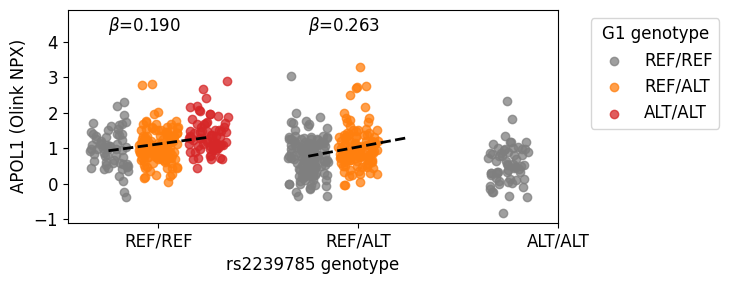

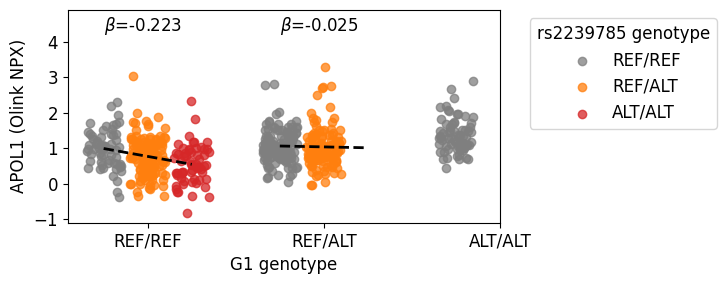

In [167]:
d_v1g1 = d_afr[(d_afr.G2==0)&(d_afr.G1M==d_afr.G1G)]
d_v1g1.dropna(inplace=True)
np.random.seed(3)
d_v1g1["rd"] = np.random.rand(d_v1g1.shape[0])
colors = ["tab:grey", "tab:orange", "tab:red"]
labels = ["REF/REF","REF/ALT", "ALT/ALT"]
#slope_rr = 
#slope_rr = 
plt.figure(figsize=(7.5,3))
for i in range(3):
    for j in range(3):
        d = d_v1g1[(d_v1g1.V1==i)&(d_v1g1.G1M==j)]
        if i==0:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], label=labels[j], alpha=0.75)
        else:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], alpha=0.75)
        #mu = d.apol1.mean()
        #plt.plot([i+(j-1)/4 - 1/5, i+(j-1)/4 + 1/5], [mu,mu], color=colors[j], linestyle="--", linewidth=2)        
#Regression line:
for i in range(2):
    model = LinearRegression()
    model.fit(pd.DataFrame(d_v1g1[(d_v1g1.V1==i)].G1M), d_v1g1[(d_v1g1.V1==i)].apol1)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot([i-1/4,i+1/4],np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")            
    plt.text(i-1/4, 4.3, f"$\\beta$={slope:.3f}")                
plt.legend(title="G1 genotype", bbox_to_anchor=(1.05,1))
plt.xlabel("rs2239785 genotype")
plt.ylabel("APOL1 (Olink NPX)")
plt.xticks([0,1,2],labels)
plt.ylim([-1.1,4.9])
plt.tight_layout()
plt.savefig("v1g1_intr.png", dpi=500)
plt.savefig("v1g1_intr.pdf", dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(7.5,3))
for i in range(3):
    for j in range(3):
        d = d_v1g1[(d_v1g1.V1==j)&(d_v1g1.G1M==i)]
        if i==0:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], label=labels[j], alpha=0.75)
        else:
            plt.scatter((d.rd-0.5)/5+i+(j-1)/4, d.apol1, color=colors[j], alpha=0.75)
        #mu = d.apol1.mean()
        #plt.plot([i - 1/5, i + 1/5], [mu,mu], color=colors[j], linestyle="--", linewidth=2)
#Regression line:
for i in range(2):
    model = LinearRegression()
    model.fit(pd.DataFrame(d_v1g1[(d_v1g1.G1M==i)].V1), d_v1g1[(d_v1g1.G1M==i)].apol1)
    slope = model.coef_[0]
    intercept = model.intercept_
    plt.plot([i-1/4,i+1/4],np.array([0,2])*slope+intercept, linestyle="--", linewidth=2, color="black")            
    plt.text(i-1/4, 4.3, f"$\\beta$={slope:.3f}")        
plt.legend(title="rs2239785 genotype", bbox_to_anchor=(1.05,1))
plt.xlabel("G1 genotype")
plt.ylabel("APOL1 (Olink NPX)")
plt.xticks([0,1,2],labels)
plt.ylim([-1.1,4.9])
plt.tight_layout()
plt.savefig("v1g1_intr2.png", dpi=500)
plt.savefig("v1g1_intr2.pdf", dpi=500)
plt.show()
plt.close()

In [ ]:
# Actually testing the p-values: REDACTED